In [1]:
import torch
import numpy as np
import matplotlib.pylab as plt
from models.dino_segmentation import DINOv2Segmenter
from models.DINO_with_SAM import DINOwithSAM
from utils.commons import load
from utils.data import FoodRecognitionDataset
from torch.utils.data import DataLoader

In [2]:
model = DINOv2Segmenter(124)
load({
    "model": model
}, "checkpoints/dino_l_seg/latest.pt")

model = model.to(1)

Using cache found in /home/wayexists/.cache/torch/hub/facebookresearch_dinov2_main
xFormers not available
xFormers not available


Context has been loaded from checkpoints/dino_l_seg/latest.pt.


In [3]:
dataset = FoodRecognitionDataset("val")
len(dataset)

loading annotations into memory...
Done (t=0.10s)
creating index...
index created!


867

In [4]:
# @torch.no_grad()
# def test():
#     torch.manual_seed(50)
#     dloader = DataLoader(dataset, shuffle=True)
#     dloader_iter = iter(dloader)

#     for i, data_item in enumerate(dloader_iter):
#         image = data_item["image"].to(1)
#         heatmap = data_item["heatmap"]
#         N, _, H, W = image.size()
        
#         mask = data_item["mask"]
#         mask = (mask > 0.5).float()
#         cnt = mask.sum().long().item()
#         mask = mask[:, :, None, None].expand(-1, -1, H, W)

#         res = model(image)
#         pred = torch.sigmoid(res["logits_heatmap"][mask == 1])
#         pred = pred.view(N, cnt, H, W).cpu()

#         heatmap = heatmap[mask == 1]
#         heatmap = heatmap.view(N, cnt, H, W)

#         print("Pred range:", pred.max(), pred.min())
        
#         image = image.permute(2, 0, 3, 1).reshape(H, N*W, 3).cpu().numpy()
#         image = (image*dataset.PIXEL_STD + dataset.PIXEL_MEAN).astype(np.uint8)

#         print("Heatmap range:", heatmap.max(), heatmap.min())

#         print("LABEL")

#         fig, ax = plt.subplots(1, cnt + 1)
#         ax[0].imshow(image)
#         ax[0].axis("off")
#         for j in range(cnt):
#             heatmap_j = heatmap[0, j][:, :, None].repeat(1, 1, 4)
#             heatmap_j[..., 2] = 0.5*heatmap_j[..., 2]
#             heatmap_j = heatmap_j.numpy()

#             ax[j + 1].imshow(image)
#             ax[j + 1].imshow(heatmap_j)
#             ax[j + 1].axis("off")

#         plt.show()

#         print("PRED")

#         fig, ax = plt.subplots(1, cnt + 1)
#         ax[0].imshow(image)
#         ax[0].axis("off")
#         for j in range(cnt):
#             pred_j = pred[0, j][:, :, None].repeat(1, 1, 4)
#             # pred_j[pred_j < 0.5] = 0
#             # pred_j[pred_j >= 0.5] = 1
#             pred_j[..., 2] = 0.5*pred_j[..., 2]
#             pred_j = pred_j.numpy()

#             ax[j + 1].imshow(image)
#             ax[j + 1].imshow(pred_j)
#             ax[j + 1].axis("off")

#         plt.show()

#         if i == 10:
#             break

In [6]:
# test()

In [18]:
@torch.no_grad()
def test():
    torch.manual_seed(921)
    dloader = DataLoader(dataset, shuffle=True)
    dloader_iter = iter(dloader)

    for i, data_item in enumerate(dloader_iter):
        image = data_item["image"].to(1)
        heatmap = data_item["heatmap"]
        _, _, H, W = image.size()
        
        res = model(image)
        existence_pred = torch.sigmoid(res["logits_existence"]).cpu()
        heatmap_pred = torch.sigmoid(res["logits_heatmap"]).cpu()

        image = image[0].cpu()
        heatmap = heatmap[0]
        existence_pred = existence_pred[0]
        heatmap_pred = heatmap_pred[0]

        exist_index = torch.arange(124)[existence_pred >= 0.85]
        if len(exist_index) == 0: continue
        
        heatmap = heatmap[exist_index]
        heatmap_pred = heatmap_pred[exist_index]
        
        image = image.permute(1, 2, 0).numpy()
        image = (image*dataset.PIXEL_STD + dataset.PIXEL_MEAN).astype(np.uint8)

        print("LABEL")

        fig, ax = plt.subplots(1, len(exist_index) + 1)
        ax[0].imshow(image)
        ax[0].axis("off")
        for j in range(len(exist_index)):
            heatmap_j = heatmap[j][:, :, None].repeat(1, 1, 4)
            heatmap_j[..., 2] = 0.5*heatmap_j[..., 2]
            heatmap_j = heatmap_j.numpy()

            ax[j + 1].imshow(image)
            ax[j + 1].imshow(heatmap_j)
            ax[j + 1].set_title(dataset.new_cat_names[exist_index[j].item()])
            ax[j + 1].axis("off")

        plt.tight_layout()
        plt.show()

        print("PRED")

        fig, ax = plt.subplots(1, len(exist_index) + 1)
        ax[0].imshow(image)
        ax[0].axis("off")
        for j in range(len(exist_index)):
            pred_j = heatmap_pred[j][:, :, None].repeat(1, 1, 4)
            pred_j[..., 2] = 0.5*pred_j[..., 2]
            pred_j = pred_j.numpy()

            ax[j + 1].imshow(image)
            ax[j + 1].imshow(pred_j)
            ax[j + 1].set_title(dataset.new_cat_names[exist_index[j].item()])
            ax[j + 1].axis("off")

        plt.tight_layout()
        plt.show()

        print("PRED (Thresholded)")

        fig, ax = plt.subplots(1, len(exist_index) + 1)
        ax[0].imshow(image)
        ax[0].axis("off")
        for j in range(len(exist_index)):
            pred_j = heatmap_pred[j][:, :, None].repeat(1, 1, 4)
            pred_j = (pred_j > 0.8).float()
            pred_j[..., 2] = 0.5*pred_j[..., 2]
            pred_j = pred_j.numpy()

            ax[j + 1].imshow(image)
            ax[j + 1].imshow(pred_j)
            ax[j + 1].set_title(dataset.new_cat_names[exist_index[j].item()])
            ax[j + 1].axis("off")

        plt.tight_layout()
        plt.show()

        if i >= 10:
            break

LABEL


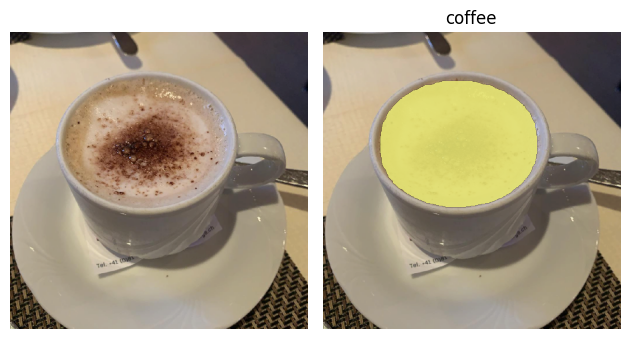

PRED


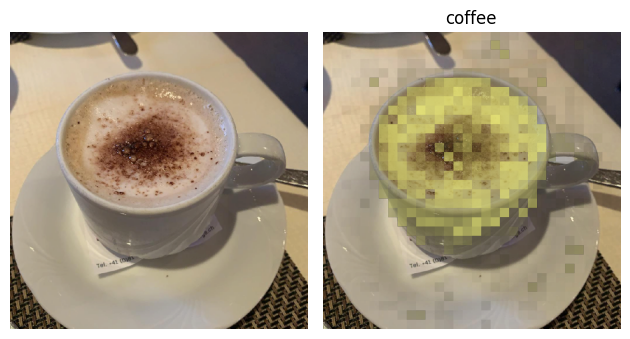

PRED (Thresholded)


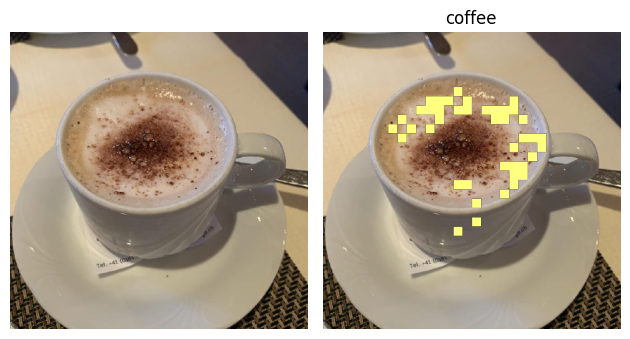

LABEL


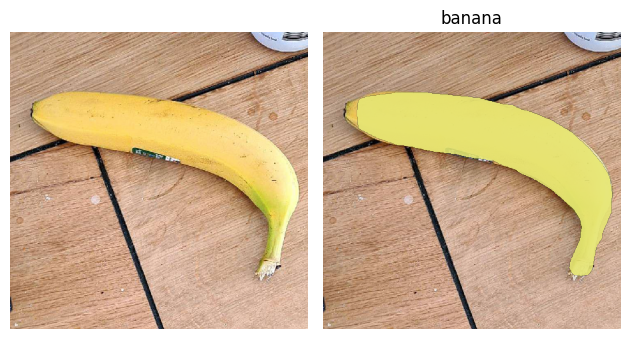

PRED


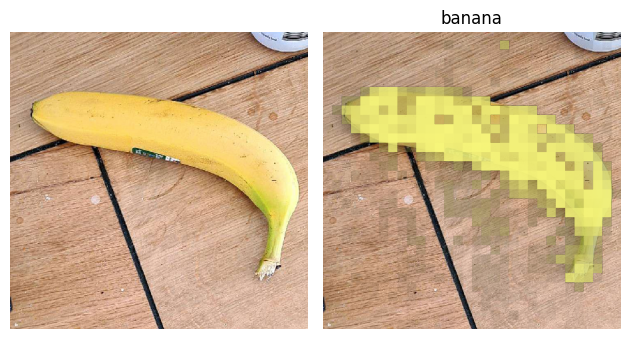

PRED (Thresholded)


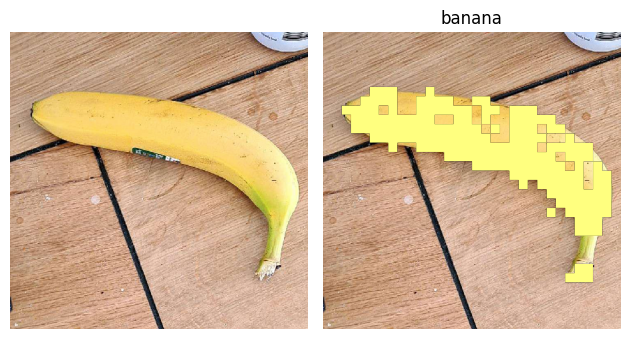

LABEL


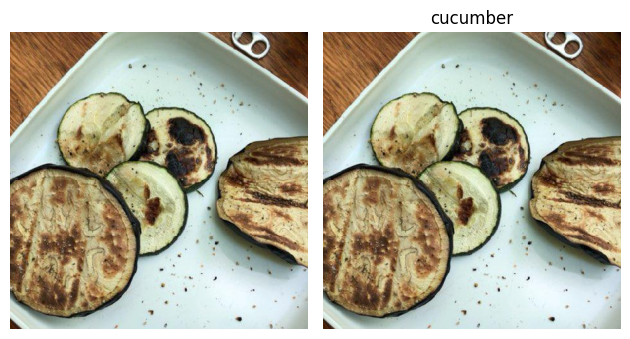

PRED


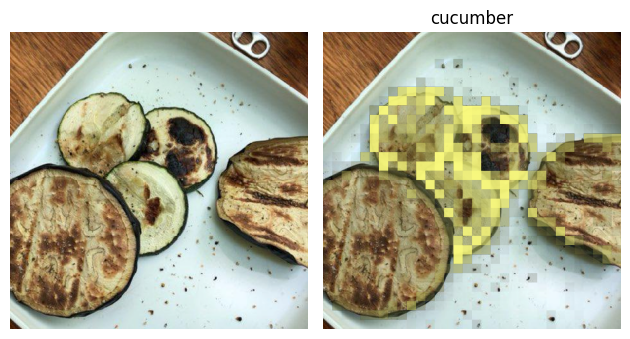

PRED (Thresholded)


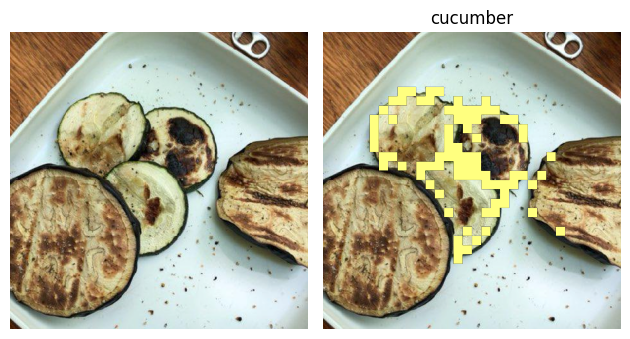

LABEL


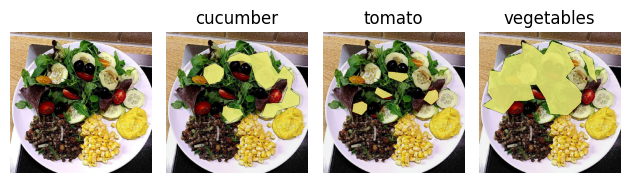

PRED


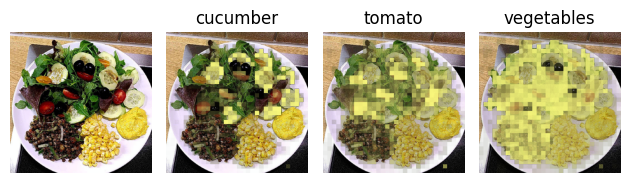

PRED (Thresholded)


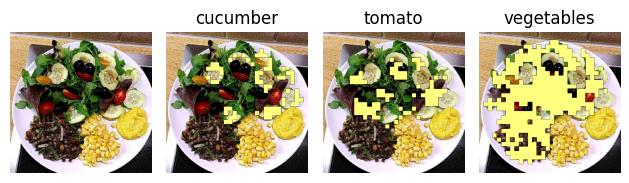

LABEL


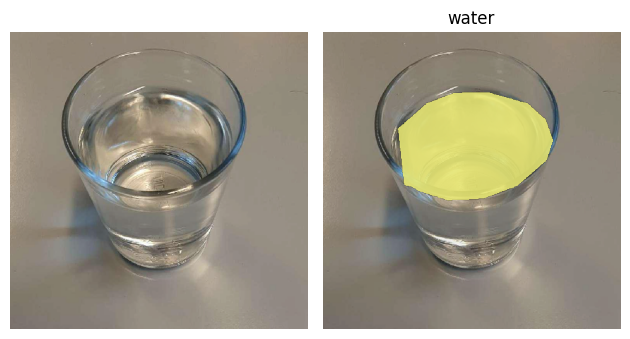

PRED


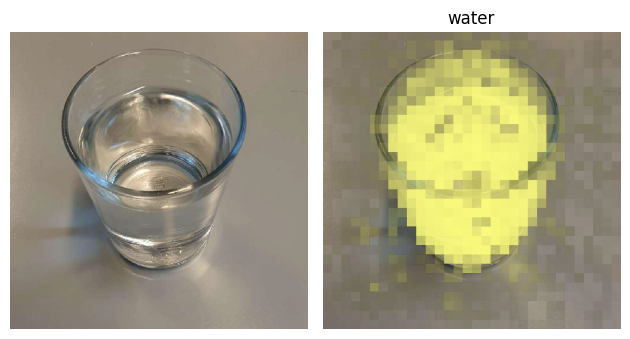

PRED (Thresholded)


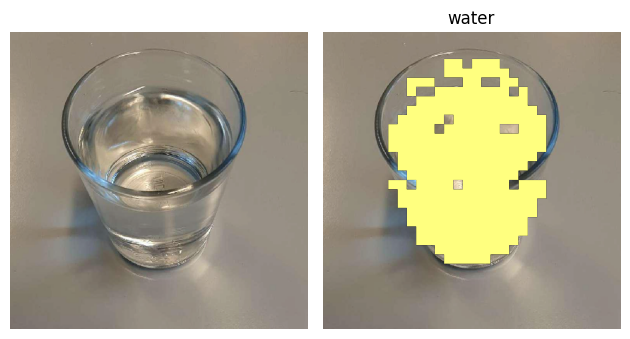

LABEL


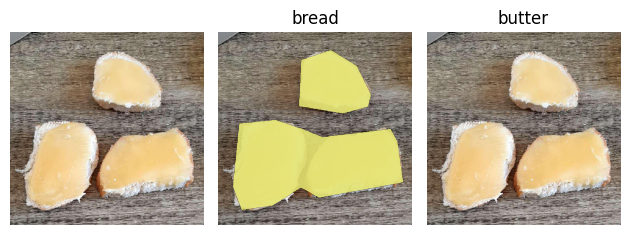

PRED


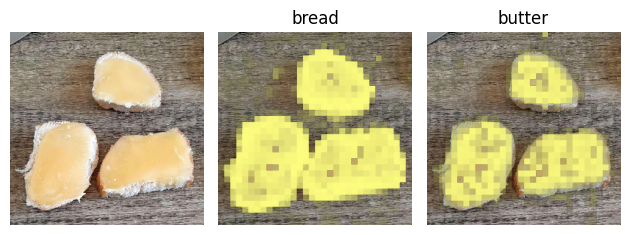

PRED (Thresholded)


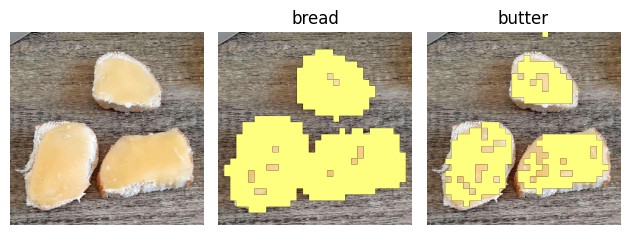

LABEL


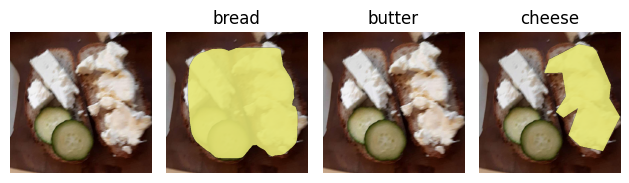

PRED


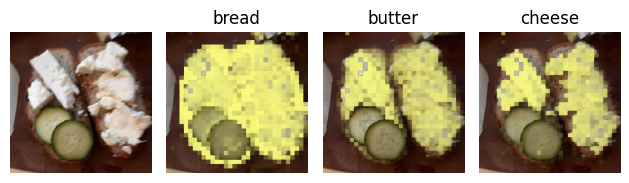

PRED (Thresholded)


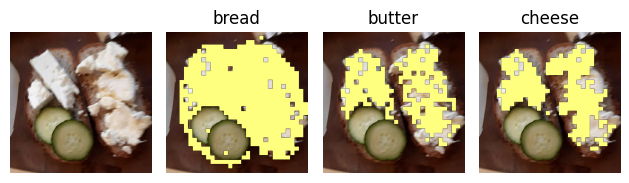

LABEL


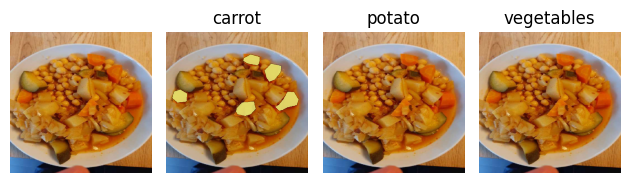

PRED


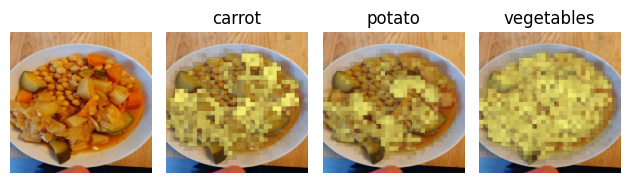

PRED (Thresholded)


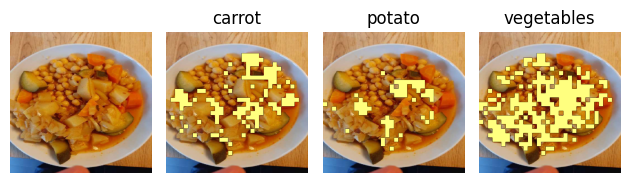

LABEL


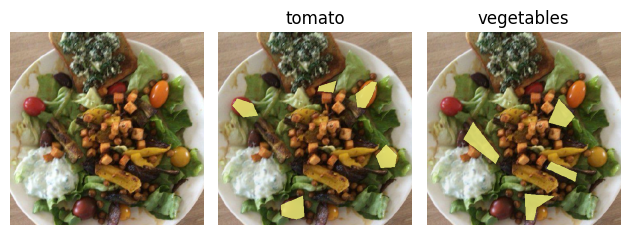

PRED


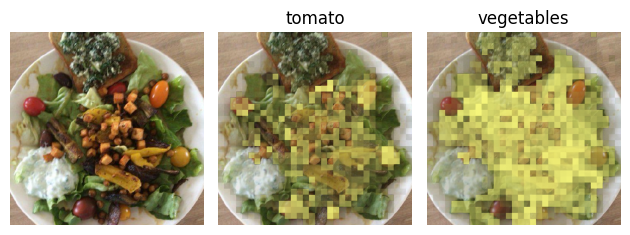

PRED (Thresholded)


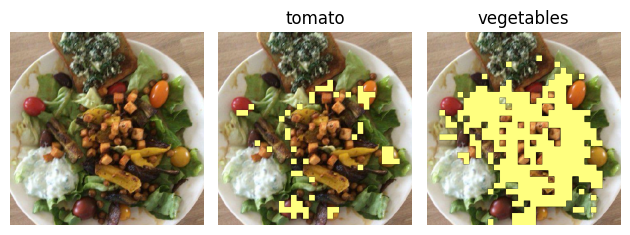

LABEL


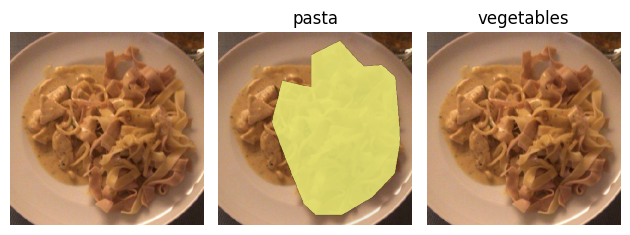

PRED


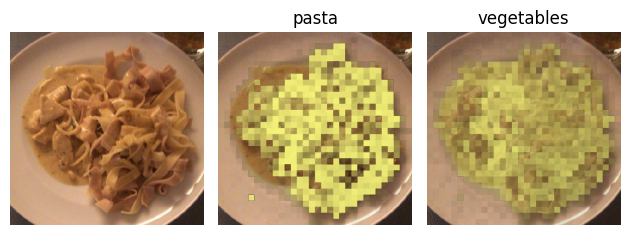

PRED (Thresholded)


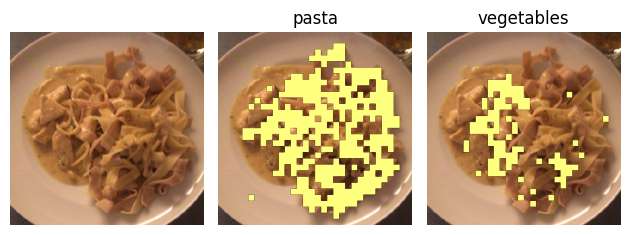

LABEL


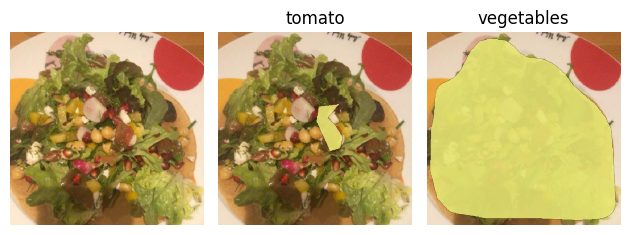

PRED


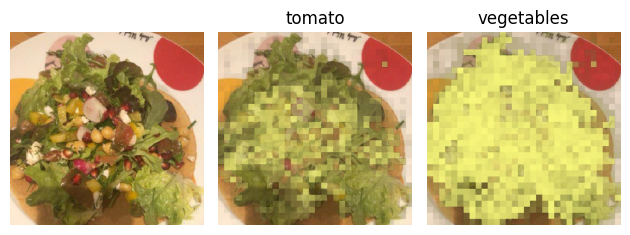

PRED (Thresholded)


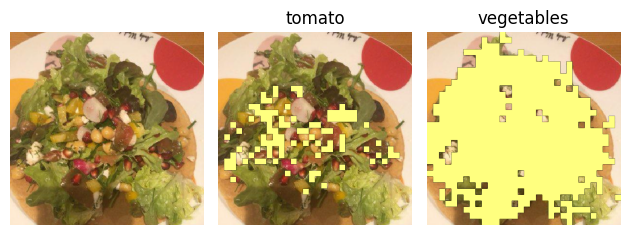

In [19]:
test()